In [3]:
import numpy as np
from matplotlib import pyplot as plt
import ctypes
import math
from scipy.integrate import solve_ivp
#Load aux shared library
clib = ctypes.CDLL('./lib/auxlib.so')

#Define the shared library functions signature
clib.henon_attractor.argtypes = [ctypes.c_float, ctypes.c_float, ctypes.c_float, ctypes.c_float,
                                 ctypes.c_float, ctypes.c_float, ctypes.c_float, ctypes.c_float,
                                 ctypes.c_int]
clib.henon_attractor.restype = ctypes.POINTER(ctypes.c_float)

<p> O artigo "Chaos, Strange Attractors, and Fractal Basin Boundaries in Nonlinear Dynamics", de Grebogi, Ott e Yorke, apresenta diversos conceitos e resultados importantes para o estudo de sistemas dinâmicos caóticos. Esse trabalho apresentará os principais pontos desse artigo e replicará os gráficos que foram utilizados para exemplificar conceitos e resultados.
</p>

<p> Primeiramente, o <en>paper</en> apresenta alguns conceitos iniciais, tais como o atrator, o atrator estranho, ou seja, atratores com formas fractais, e dimensão, definida no artigo como sendo a dimensão de <en>counting boxes</en>. A seguir, mostra-se o atrator caótico do mapa de Henón (para a = 1.4 e b = 0.3)
</p>

In [2]:
def henon_attractor(a, b, xmin, xmax, ymin, ymax, ndisc, niter):
    henon_map = lambda x, y: (a-x**2+b*y, x)
    x = y = 0.0

    for _ in range(ndisc):
        x, y = henon_map(x, y)

    X = []
    Y = []
    # A função clib.henon_attractor faz o cálculo de 10000 em 10000 para evitar Stack Overflow
    for i in range(math.ceil(niter/10000.0)):
        c_niter = min(10000, niter-i*10000)
        result = clib.henon_attractor(a, b, x, y, xmin, xmax, ymin, ymax, c_niter)
        orbit = ctypes.cast(result, ctypes.POINTER(ctypes.c_float * (2 * c_niter)))
        X += orbit[0][:c_niter]
        Y += orbit[0][c_niter:]
        x = X[-1]
        y = Y[-1]
    
    return np.array(X), np.array(Y)

Xa, Ya = henon_attractor(1.4, 0.3, -2, 2, -2, 2, 100, 10000)
Xb, Yb = henon_attractor(1.4, 0.3, 0.8, 1.1, 0.7, 0.95, 100, 10000)
Xc, Yc = henon_attractor(1.4, 0.3, 0.93, 0.965, 0.84, 0.875, 100, 10000)

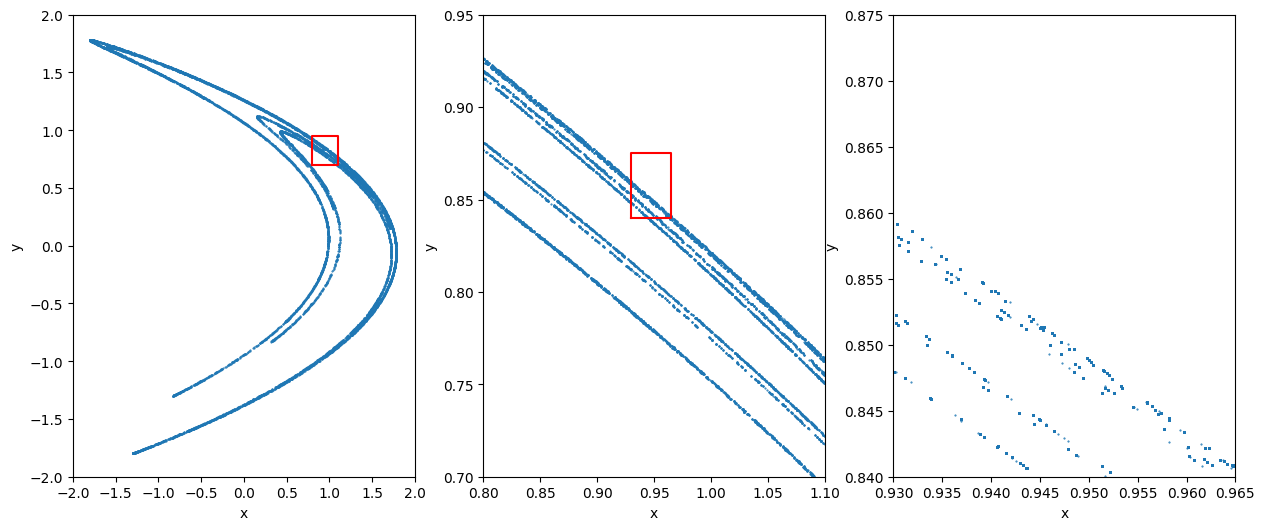

In [3]:
_, axs = plt.subplots(1,3, figsize = (15, 6), squeeze=False)

ax = axs[0][0]
ax.scatter(Xa, Ya, marker = '.', s = 1)
ax.plot([0.8, 0.8, 1.1, 1.1, 0.8], [0.7, 0.95, 0.95, 0.7, 0.7], color = 'r')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_xlim(-2,2)
ax.set_ylim(-2,2)

ax = axs[0][1]
ax.scatter(Xb, Yb, marker = '.', s = 1)
ax.plot([0.93, 0.93, 0.965, 0.965, 0.93], [0.84, 0.875, 0.875, 0.84, 0.84], color = 'r')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_xlim(0.8,1.1)
ax.set_ylim(0.7,0.95)

ax = axs[0][2]
ax.scatter(Xc, Yc, marker = '.', s = 1)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_xlim(0.93,0.965)
ax.set_ylim(0.84,0.875)
plt.show()

Percebe-se que o atrator tem formato fractal, de modo que independentemente do zoom dado na imagem os padrões de linhas estarão presentes. Os atratores caóticos também são vistos para o pêndulo amortecido forçado periodicamente, cujo movimento é determinado pela EDO:

$$
\frac{d^2\theta}{dt^2} + \frac{0.22d\theta}{dt} + \sin{\theta} = 2.7\cos{t}
$$

Se considerarmos o mapa obtido ao considerar os tempos $t = 2k\pi$ temos a figura a seguir.

In [4]:
def pendulum_ODE(t, y, v, f):

    theta, theta_ = y
    dtheta_dt = theta_
    dtheta_dt_2 = -v*theta_ - np.sin(theta) + f*np.cos(t)

    return[dtheta_dt, dtheta_dt_2]

t_points = np.arange(0, 100000, 2*np.pi)
initial_conditions = [0, 0]
t_span = (0, t_points[-1])


v = 0.22
f = 2.7

solution = solve_ivp(pendulum_ODE, t_span, initial_conditions, t_eval=t_points, args=(v,f), method='DOP853', max_step = 0.2)

theta_values = np.array(solution.y[0])
theta_values = np.mod(theta_values, 2*np.pi)
theta_values = np.where(theta_values > np.pi, theta_values-2*np.pi, theta_values)

dtheta_values = solution.y[1]

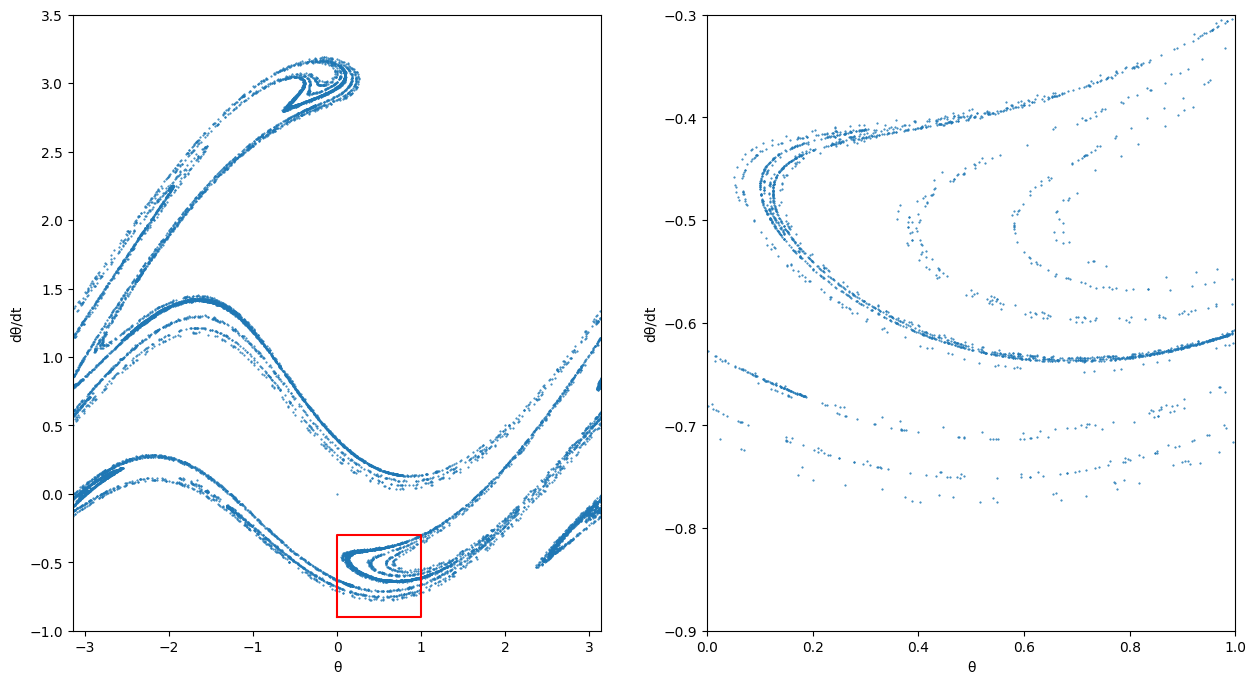

In [5]:
fig, axs = plt.subplots(1,2, squeeze=False, figsize = (15,8))

ax = axs[0][0]
ax.scatter(theta_values, dtheta_values, s = 1, marker = ".")
ax.plot([0,0,1,1,0], [-0.9, -0.3, -0.3, -0.9, -0.9], color = 'r')
ax.set_xlim(-np.pi,np.pi)
ax.set_ylim(-1,3.5)
ax.set_xlabel('θ')
ax.set_ylabel('dθ/dt')

ax = axs[0][1]
ax.scatter(theta_values, dtheta_values, s = 1, marker = ".")
ax.set_xlim(0,1)
ax.set_ylim(-0.9,-0.3)
ax.set_xlabel('θ')
ax.set_ylabel('dθ/dt')

plt.show()

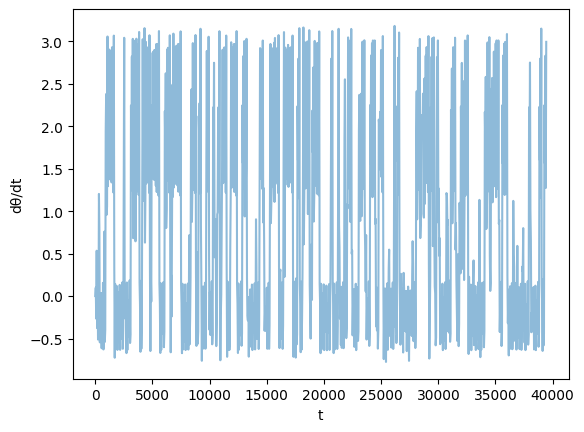

In [6]:
time = t_points[0:1000]*2*np.pi
_, ax = plt.subplots()
ax.plot(time, dtheta_values[0:1000], alpha = 0.5)
ax.set_xlabel("t")
ax.set_ylabel('dθ/dt')
plt.show()

In [4]:
# Function P was not given
P = lambda phi, theta: np.sin(2*np.pi*(phi+theta))*np.cos(2*np.pi*(phi-theta))

def iterate_torus(w1, w2, eps, ndisc, niter):
    def iterate(phi, theta):
        result = np.array([phi+w1, theta+w2]) + eps*P(phi, theta)
        return np.mod(result, 1) 
    
    grid = np.zeros((1000, 1000))
    
    phi, theta = 0, 0
    for _ in range(ndisc):
        phi, theta = iterate(phi, theta)

    for _ in range(niter):
        phi, theta = iterate(phi, theta)
        grid[int(phi*1000)][int(theta*1000)] = 1

    return grid

grid_a = iterate_torus(0.54657, 0.36736, 0.75, 100, 100000)
grid_b = iterate_torus(0.45922, 0.53968, 0.50, 100, 100000)
grid_c = iterate_torus(0.41500, 0.73500, 0.60, 100, 100000)

Text(0, 0.5, 'ψ')

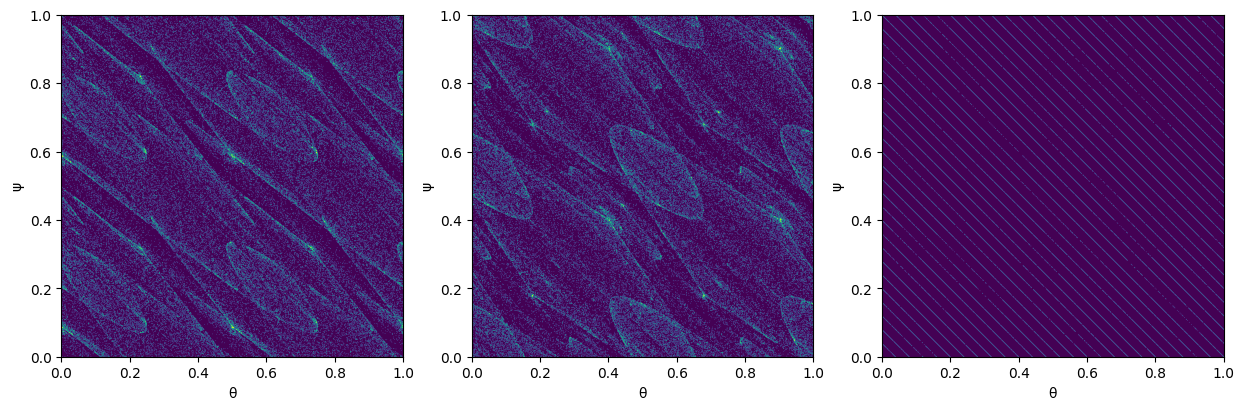

In [5]:
fig, axs = plt.subplots(1,3, squeeze=False, figsize = (15,6))

ax = axs[0][0]
ax.imshow(grid_a, extent = [0, 1, 0, 1])
ax.set_xlabel('θ')
ax.set_ylabel('ψ')

ax = axs[0][1]
ax.imshow(grid_b, extent = [0, 1, 0, 1])
ax.set_xlabel('θ')
ax.set_ylabel('ψ')

ax = axs[0][2]
ax.imshow(grid_c, extent = [0, 1, 0, 1])
ax.set_xlabel('θ')
ax.set_ylabel('ψ')


In [6]:
def get_periodic_points(f, x0, n_discard, n_iter, n_digits):
    """
    params
    function f: map to be applied
    float x0: initial point
    n_discard: the amount of first iterations that will be discarted
    n_iter: the amount of points that will be collected after the discard
    n_digits: number of decimals to be rounded into

    output
    list: periodic points for the given function
    """

    #iterate n_discard times
    for _ in range(n_discard):
        x0 = f(x0)
        if abs(x0) > 100:
            return None

    #iterate n_iter times and save values in a dict (faster than list for searching keys)
    y = dict()
    for _ in range(n_iter):
        x0 = f(x0)
        if abs(x0) > 100:
            return None
        rounded = round(x0, n_digits)
        if rounded in y:
            return y.keys()
        y[rounded] = True

    return y.keys()

def quadratic_map(c):
    return lambda x: c - x**2

def bifurcation_map(f_getter, x0, start, end, n_discard, n_iter, n_digits):
    X_plot = list()
    Y_plot = list()
    C = np.linspace(start, end, 5000)
    for c in C:
        y = get_periodic_points(f_getter(c), x0, n_discard, n_iter, n_digits)
        if y != None:
            Y_plot += y
            X_plot += [c for i in range(len(y))]
    return X_plot, Y_plot

Xa, Ya = bifurcation_map(quadratic_map, 0, -0.4, 2, 2000, 2000, 5)
Xb, Yb = bifurcation_map(quadratic_map, 0, 1.72, 1.82, 2000, 2000, 5)

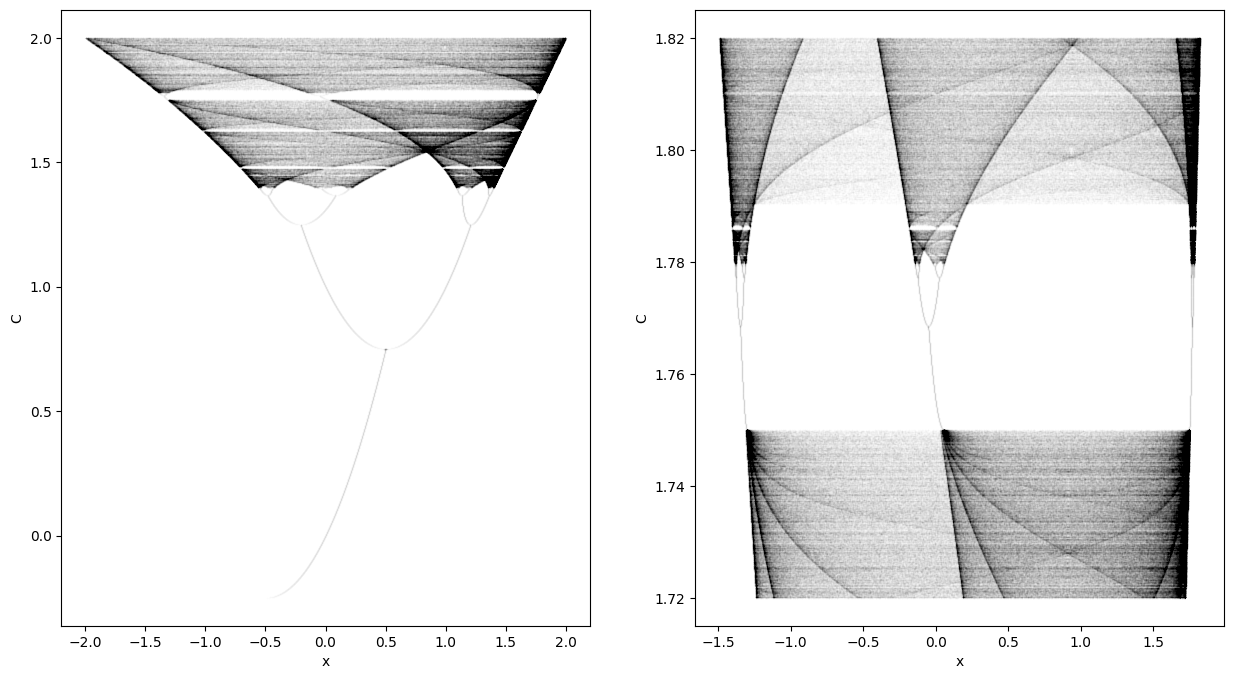

In [7]:
_, axs = plt.subplots(1, 2, squeeze = False, figsize = (15, 8))
ax = axs[0][0]
ax.scatter(Ya, Xa, s = 1, marker = ".", color = 'k', alpha = 0.01)
ax.set_xlabel('x')
ax.set_ylabel('C')
ax = axs[0][1]
ax.scatter(Yb, Xb, s = 1, marker = ".", color = 'k', alpha = 0.01)
ax.set_xlabel('x')
ax.set_ylabel('C')
plt.show()

In [8]:
X, Y = bifurcation_map(quadratic_map, 0, 1.4008, 1.401, 10000, 2000, 5)

In [26]:
def logistic_map(a):
    return lambda x: a*x*(1-x)

In [27]:
def find_bifurcation(f_getter, n_branch, x0, start, end, n_discard, n_iter, n_digits):
    C = np.linspace(start, end, 5000)
    for i in range(len(C)):
        y = get_periodic_points(f_getter(C[i]), x0, n_discard, n_iter, n_digits)
        if y != None:
            if len(y) >= 2*n_branch:
                return C[i-1], C[i]
    print(n_branch)
    print(start, end)
    raise ValueError

def get_bif_points(f_getter, n_max, precision, x0, start0, end0, n_discard, n_iter, n_digits):
    points = []
    n_branch = 1
    start, end = start0, end0
    while n_branch < 2**n_max:
        while end - start > precision:
            start, end = find_bifurcation(f_getter, n_branch, x0, start, end, n_discard, n_iter, n_digits)
        points.append(start)
        end = end0
        n_branch *= 2
    return [(points[i+1]-points[i])/(points[i+2]-points[i+1]) for i in range(len(points)-2)], points

In [53]:
quad_ratio, quad_points = get_bif_points(quadratic_map, 7, 0.00001, 0, 0, 1.42, 10000, 500, 5)

In [57]:
log_ratio, log_points = get_bif_points(logistic_map, 7, 0.00001, 0.2, 2.8, 3.6, 10000, 500, 5)

In [59]:
print(log_ratio)
print(quad_ratio)
print(log_points)
print(quad_points)

[4.751913047979255, 4.648061542759522, 4.659848991123574, 4.697812095841988, 4.5169860521555405]
[4.227637897509926, 4.544067539645241, 4.633196008098325, 4.659643468124013, 4.6269089817518125]
[2.9989914286117876, 3.449245339211991, 3.543997475047404, 3.564382776524966, 3.5687574465016954, 3.5696886608388123, 3.569894819176776]
[0.7490649712258914, 1.2495577286781996, 1.3679436381590229, 1.3939964880447149, 1.3996195719462279, 1.4008263346395498, 1.4010871486512542]


In [101]:
!#todo deixar r menos carteado

def k_window_ratio(f_getter, k, x0, start0, end0, n_discard, n_iter, n_digits):
    c = np.linspace(start0, end0, 5000)
    find_k_periodic = True
    find_2k_periodic = True
    find_window_end = True
    i = 0
    c0 = cd = cc = 0
    while(find_k_periodic):
        y = get_periodic_points(f_getter(c[i]), x0, n_discard, n_iter, n_digits)
        if y != None:
            if len(y) == k:
                find_k_periodic = False
                c0 = c[i]
        i += 1
    while(find_2k_periodic):
        y = get_periodic_points(f_getter(c[i]), x0, n_discard, n_iter, n_digits)
        if y != None:
            if len(y) == 2*k:
                find_2k_periodic = False
                cd = c[i]
        i += 1

    while(find_window_end and i < 5000):
        y = get_periodic_points(f_getter(c[i]), x0, n_discard, n_iter, n_digits)
        test_counter = 0
        if y != None:
            test_points = np.linspace(min(y), max(y), 10)
            r = (max(y)-min(y))/20
            for p in range(len(test_points)):
                for point in y:
                    if abs(point - test_points[p]) < r:
                        test_counter += 1
                        break
                if test_counter != p + 1:
                    break
            if len(test_points) == test_counter:
                find_window_end = False
                cc = c[i]
        i += 1
    
    return c0, cd, cc
    

In [102]:
c0_quad, cd_quad, cc_quad = k_window_ratio(quadratic_map, 3, 0, 1.749, 1.791, 10000, 10000, 5)

In [104]:
c0_log, cd_log, cc_log = k_window_ratio(logistic_map, 3, 0.1, 3.82, 3.87, 10000, 10000, 5)

In [105]:
print(f"quadratic: {(cc_quad-c0_quad)/(cd_quad-c0_quad)}, logistic: {(cc_log-c0_log)/(cd_log-c0_log)}, 9/4 = {9/4}")

quadratic: 2.180208806173414, logistic: 2.175344563552868, 9/4 = 2.25


In [108]:
c0_quad, cd_quad, cc_quad = k_window_ratio(quadratic_map, 5, 0, 1.5, 1.7, 10000, 10000, 5)
c0_log, cd_log, cc_log = k_window_ratio(logistic_map, 5, 0.1, 3.7, 3.8, 10000, 10000, 5)

In [109]:
print(f"quadratic: {(cc_quad-c0_quad)/(cd_quad-c0_quad)}, logistic: {(cc_log-c0_log)/(cd_log-c0_log)}, 9/4 = {9/4}")

quadratic: 2.2400000000000024, logistic: 2.244897959183609, 9/4 = 2.25
